### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
BED_FILE_NAME = "union13callableMQonlymerged_addcert_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs_v2.19_2mindatasets_5minYesNoRatio.bed"
# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'70-30truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"
# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/160524/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

<h3> Load VCFs and Prepare DF

In [4]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
bed.reverse()

reading BED file
Bed File Loaded


In [5]:
## LOAD TRUTH SET VCF
truthBed = copy.deepcopy(bed)
dfTruth = aVCF.loadVaraintsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,truthBed)

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
Number variants loaded: 1005479


In [6]:
# LOAD SAMPLE VCF + match to truth set
df = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,bed)
df['Truth']=df.chromPos.isin(dfTruth['chromPos']) 


reading vcf file: CPCT11111111R_CPCT11111111T_merged_somatics.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
reading VCF File line: 1200000
reading VCF File line: 1300000
Number variants loaded: 995943


<h3> High Level Stats

In [7]:
#PRECISION + SENSITIVITY by caller
outputdata = []

for columnName in list(df):
    if columnName.endswith('allele'):
        myCaller = columnName[:-6]
        variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
        for variantType in variantTypes:
            truePositives = len(df[(df[myCaller+'allele'] != '')&(df['Truth'] == True) &(df['variantType'] == variantType)])
            falseNegatives = len(df[(df[myCaller+'allele'] == '')&(df['Truth'] == True) &(df['variantType'] == variantType)])
            positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
            truthSet = positives + falseNegatives 
            if positives > 0:
                outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
outputDF.sort_values(['variantType','caller'])

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,54892,7690,758,46444,0.9103,0.1401
1,INDEL,strelka,54460,21063,326,33071,0.9848,0.3868
3,INDEL,varscan,56351,50811,2217,3323,0.9582,0.9017
5,SNP,freebayes,911135,140258,4559,766318,0.9685,0.1539
4,SNP,mutect,925567,849560,18991,57016,0.9781,0.9179
0,SNP,strelka,927131,868898,20555,37678,0.9769,0.9372
2,SNP,varscan,914516,782133,7940,124443,0.9900,0.8552


In [8]:
dfTruth[['variantType','pos']].groupby(['variantType']).agg('count')

,pos
variantType,
INDEL,78123
SNP,927356


In [9]:
df[['variantType','pos']].groupby(['variantType']).agg('count')

,pos
variantType,
INDEL,57221
SNP,938722


In [10]:
df.head(1)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,strelkaallele,strelkaallelicFreq,strelkareadDepth,strelkareadDepthBucket,varscanallele,varscanallelicFreq,varscanreadDepth,varscanreadDepthBucket,mutectallele,mutectallelicFreq,mutectreadDepth,mutectreadDepthBucket,freebayesallele,freebayesallelicFreq,freebayesreadDepth,freebayesreadDepthBucket,patientName,Truth
0,1,713641,1:713641,1.002863,A,mutect,1,SNP,,,,,,,,,,T,0.1,111,64,,,,,CPCT11111111,False


<h3> SNP

In [11]:
snpdf = df[(df.variantType == 'SNP')]

In [12]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

,pos
Truth,
False,32146
True,906576


In [13]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

Truth,False,True
numCallers,,
1,17411,43401
2,10163,113483
3,3980,628286
4,592,121406


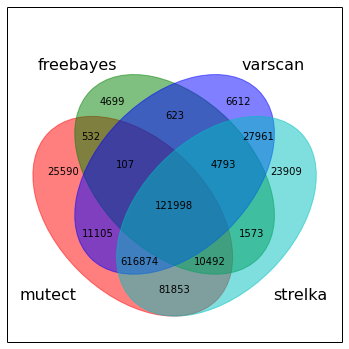

In [14]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [15]:
indeldf= df[(df.variantType == 'INDEL')]

In [16]:
pd.pivot_table(indeldf, values='pos', index=['numCallers','vennSegment'], columns=['Truth'], aggfunc='count')

Truth                                          False    True 
numCallers vennSegment                                       
1          freebayes                           404.0    677.0
           strelka                              72.0    967.0
           varscan                            1060.0  19433.0
2          filterInvarscan-freebayes             1.0      1.0
           freebayes                           278.0    247.0
           strelka                              94.0    770.0
           strelka-filterInvarscan               NaN     11.0
           strelka-freebayes                    14.0    364.0
           strelka-varscan                      68.0   7939.0
           varscan                             988.0  12052.0
           varscan-freebayes                    13.0    443.0
3          strelka-filterInvarscan-freebayes     NaN      2.0
           strelka-varscan-freebayes             8.0   3177.0
4          filterInvarscan-freebayes             2.0      1.0
           strelka-filterInvarscan               1.0     12.0
           strelka-freebayes                     8.0    298.0
           strelka-varscan                      46.0   5260.0
           varscan-freebayes                    15.0    217.0
6          strelka-filterInvarscan-freebayes     NaN      2.0
           strelka-varscan-freebayes            15.0   2261.0

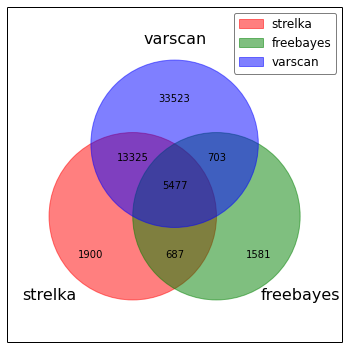

In [17]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

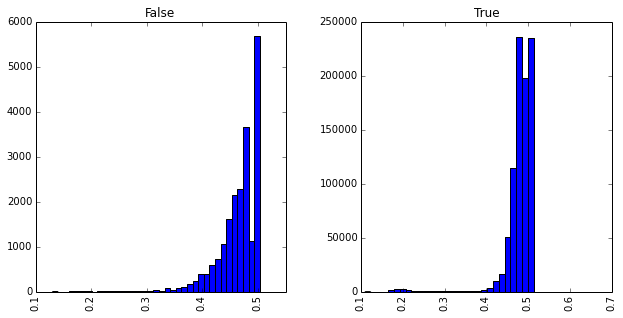

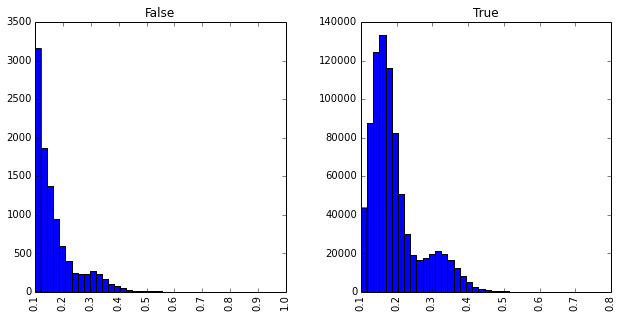

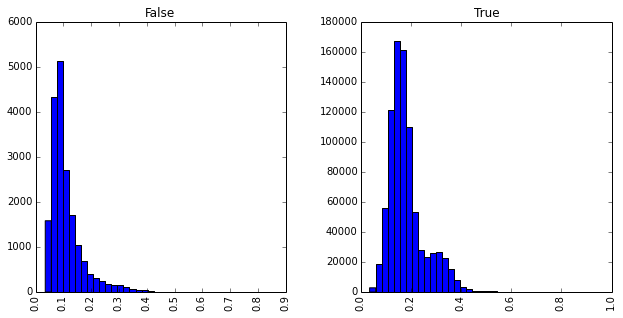

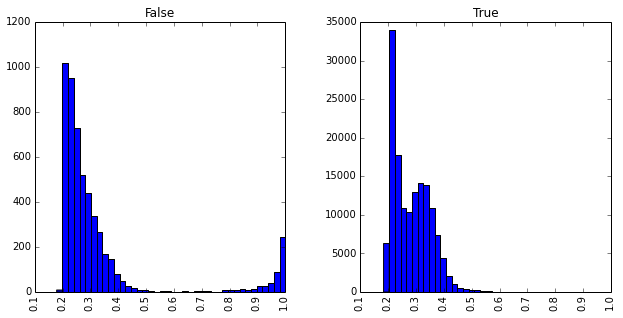

In [54]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

array([<matplotlib.axes.AxesSubplot object at 0x1286d1350>,
       <matplotlib.axes.AxesSubplot object at 0x128d96990>], dtype=object)

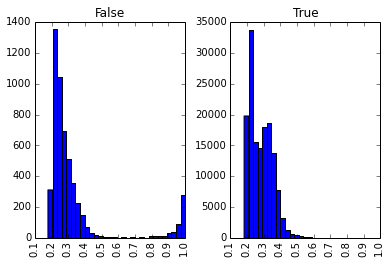

In [48]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

<h3> Allelic Depth

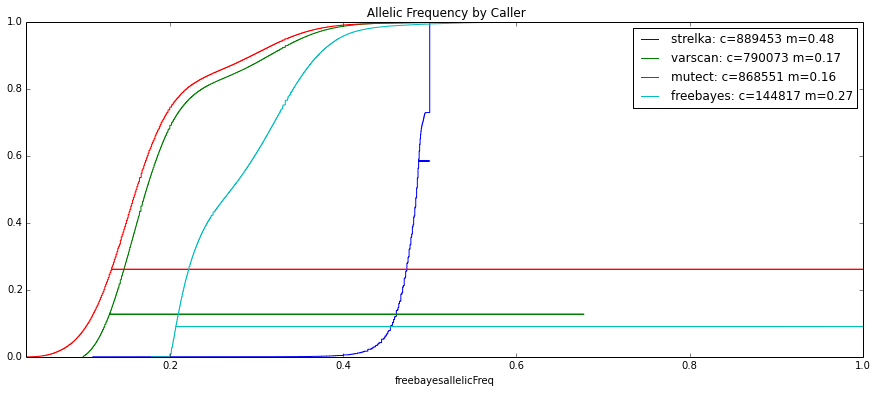

In [19]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[snpdf[columnName] != ''][columnName[:-6] + 'allelicFreq']
        ser = ser.sort_values()
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller",figsize=[15,6])

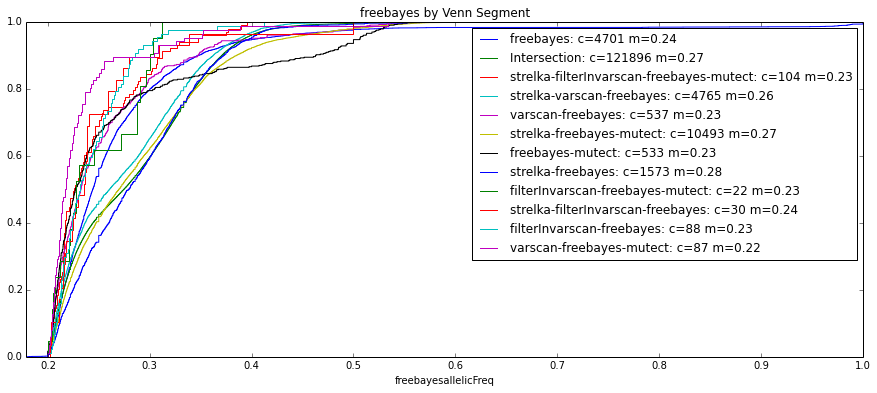

In [20]:
# BY CALLER BY VENN SEGMENT - Single Caller
myCaller = 'freebayes'
vennSegments = snpdf[snpdf[myCaller+'allele'] != ''].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '')][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" by Venn Segment",figsize=[15,6])

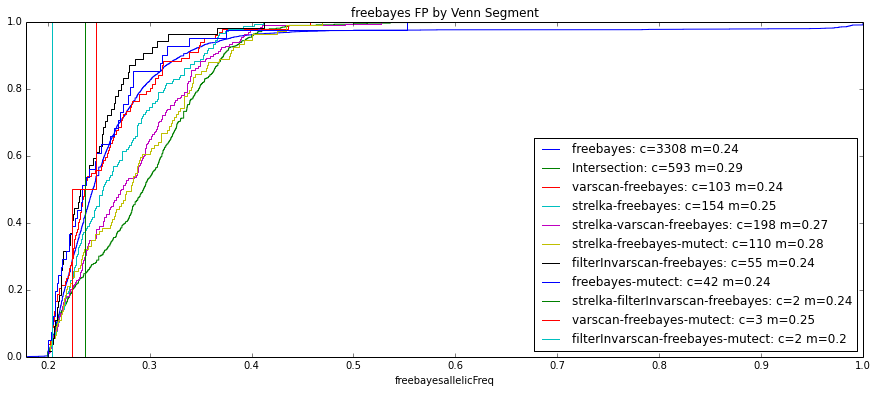

In [21]:
# BY CALLER BY VENN SEGMENT - Single Caller
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

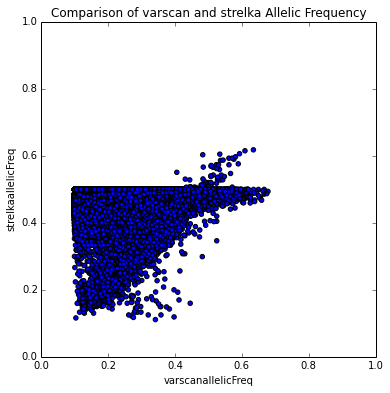

In [22]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

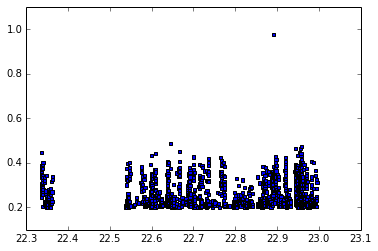

In [23]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

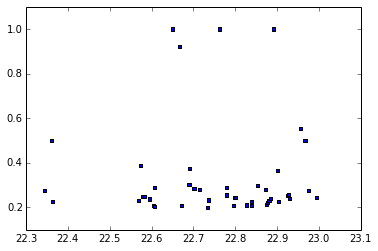

In [24]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [25]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

"\nsorteddf = df.sort(['chromFrac'], ascending=1)\nsorteddf['nextRef'] = sorteddf['ref'].shift(-2)\nsorteddf['nextPos'] = sorteddf['pos'].shift(-2)\nsorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)\nsorteddf['nextVT'] = sorteddf['variantType'].shift(-2)\nsorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)\nsorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)\nsorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)\nsorteddf['lengthRef'] = sorteddf['ref'].str.len()\nsorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)\n\noverlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]\noverlapdf.head(20)\n"

In [26]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''

"\nfiltereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1']))                        & (overlapdf.vennSegment.str.contains('varscan'))                        #& (~overlapdf.nextVennSegment.str.contains('varscan'))                        & (overlapdf.variantType == 'INDEL')                        #& (overlapdf.variantSubType == 'DELETE')\n                       & (overlapdf.variantType == overlapdf.nextVT)]\nfiltereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2',             'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()\n"